In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
#Read in the raw data from WorldBank
data_df = pd.read_csv(
    Path("./Resources/03c00fd0-1cf9-46e8-aa22-40e2b0adbc27_Data.csv"), 
)

data_df.head()

,Country Name,Country Code,Series Name,Series Code,1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],...,2013 [YR2013],2014 [YR2014],2015 [YR2015],2016 [YR2016],2017 [YR2017],2018 [YR2018],2019 [YR2019],2020 [YR2020],2021 [YR2021],2022 [YR2022]
0,Argentina,ARG,"Adolescent fertility rate (births per 1,000 wo...",SP.ADO.TFRT,68.608,70.631,72.626,74.274,75.771,75.957,...,69.167,67.791,65.395,61.852,57.783,51.029,46.153,39.866,39.065,..
1,Argentina,ARG,"Agriculture, forestry, and fishing, value adde...",NV.AGR.TOTL.ZS,11.9525224881086,10.2308377488651,6.5839104917193,8.15217071197931,8.0871421139688,7.5044274778029,...,6.05291843670451,6.71270351428559,5.1566859021408,6.26456582010254,5.23162237725058,4.53787889681146,5.3185559967348,6.12846695022316,7.13154104672929,6.44416917103214
2,Argentina,ARG,"Annual freshwater withdrawals, total (% of int...",ER.H2O.FWTL.ZS,..,..,..,9.45205479452055,9.46970620044521,9.48735760633562,...,12.9075342465753,12.9075342465753,12.9075342465753,12.9075342465753,12.9075342465753,12.9075342465753,12.9075342465753,12.9075342465753,..,..
3,Argentina,ARG,Births attended by skilled health staff (% of ...,SH.STA.BRTC.ZS,..,..,..,..,..,..,...,97,99.6,99.6,98.4,93.9,99.5,99.6,98.8,..,..
4,Argentina,ARG,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,..,..,..,..,..,..,...,4.34225013023383,4.20911189491323,4.30191380564475,4.20181586904703,4.07011168693629,3.97565074444479,3.74202981162433,3.4056175404138,..,..


In [3]:
# We don't need these two columns
data_df = data_df.drop(columns=['Country Name','Series Code']).copy()

In [4]:
# Group by country and then by series name so we can provide per-country analysis
grouped = data_df.groupby([
    'Country Code',
    'Series Name'
    ])

In [5]:
# We want to return all the data for the aggregation so just return the data during aggregation
grouped = grouped.agg(lambda x: x)

# Replace the default missing data value with NaN
grouped = grouped.replace('..', np.nan)

In [6]:
# Manually add dummy variables to allow us to train a model on a per country basis 
# while still including all information of the other countries
grouped_transpose = grouped.T.copy()

country_codes = list(set(grouped.index.get_level_values(0)))

df = None

for code in country_codes:
    country_data = grouped_transpose[code]
    country_data['country_code'] = code
    country_data = country_data.reset_index(drop=True)
    
    if df is None:
        df = pd.DataFrame(columns=country_data.columns)
    
    df = pd.concat([df, country_data], ignore_index=True)

df = df[df['Fertility rate, total (births per woman)'].notna()]

df.head()

/var/folders/s7/5vbrzq7x741_dp271_qgj7wc0000gn/T/ipykernel_54616/819064186.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['country_code'] = code
/var/folders/s7/5vbrzq7x741_dp271_qgj7wc0000gn/T/ipykernel_54616/819064186.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_data['country_code'] = code
/var/folders/s7/5vbrzq7x741_dp271_qgj7wc0000gn/T/ipykernel_54616/819064186.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Series Name,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Agriculture, forestry, and fishing, value added (% of GDP)","Annual freshwater withdrawals, total (% of internal resources)",Births attended by skilled health staff (% of total),CO2 emissions (metric tons per capita),"Contraceptive prevalence, any method (% of married women ages 15-49)",Domestic credit provided by financial sector (% of GDP),"Droughts, floods, extreme temperatures (% of population, average 1990-2009)",Electric power consumption (kWh per capita),Energy use (kg of oil equivalent per capita),...,"School enrollment, primary and secondary (gross), gender parity index (GPI)","School enrollment, secondary (% gross)",Statistical Capacity Score (Overall Average) (scale 0 - 100),Surface area (sq. km),Tax revenue (% of GDP),Terrestrial and marine protected areas (% of total territorial area),Time required to start a business (days),"Total debt service (% of exports of goods, services and primary income)",Urban population growth (annual %),country_code
0,84.022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,181040,NaN,NaN,NaN,NaN,15.9246017689686,KHM
1,71.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,181040,NaN,NaN,NaN,NaN,14.8719289553475,KHM
2,62.524,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,181040,NaN,NaN,NaN,NaN,-189.743416916327,KHM
3,55.602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,181040,NaN,NaN,NaN,NaN,0.923319382116819,KHM
4,46.097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,181040,NaN,NaN,NaN,NaN,2.99480621782675,KHM


In [7]:
# Save the output to JSON for repeat use
df.to_json(Path('processed.json'))

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12589 entries, 0 to 13298
Data columns (total 57 columns):
 #   Column                                                                       Non-Null Count  Dtype 
---  ------                                                                       --------------  ----- 
 0   Adolescent fertility rate (births per 1,000 women ages 15-19)                12589 non-null  object
 1   Agriculture, forestry, and fishing, value added (% of GDP)                   9381 non-null   object
 2   Annual freshwater withdrawals, total (% of internal resources)               6132 non-null   object
 3   Births attended by skilled health staff (% of total)                         3073 non-null   object
 4   CO2 emissions (metric tons per capita)                                       7342 non-null   object
 5   Contraceptive prevalence, any method (% of married women ages 15-49)         1324 non-null   object
 6   Domestic credit provided by financial sector (% of 

In [9]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Encode (convert to dummy variables) the country_code column
scaled_data = enc.fit_transform(df[['country_code']])

df_country_code = pd.DataFrame(data=scaled_data, columns=enc.get_feature_names_out(['country_code']))

df_country_code

/Users/davidrosenbloom/anaconda3/envs/dev/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,country_code_ABW,country_code_AFE,country_code_AFG,country_code_AFW,country_code_AGO,country_code_ALB,country_code_AND,country_code_ARB,country_code_ARE,country_code_ARG,...,country_code_VIR,country_code_VNM,country_code_VUT,country_code_WLD,country_code_WSM,country_code_XKX,country_code_YEM,country_code_ZAF,country_code_ZMB,country_code_ZWE
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12587,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
df_scaled = df.drop(columns='country_code')

scaled_data = StandardScaler().fit_transform(df_scaled)

df_scaled = pd.DataFrame(data=scaled_data, columns=df_scaled.columns)

df_scaled

Series Name,"Adolescent fertility rate (births per 1,000 women ages 15-19)","Agriculture, forestry, and fishing, value added (% of GDP)","Annual freshwater withdrawals, total (% of internal resources)",Births attended by skilled health staff (% of total),CO2 emissions (metric tons per capita),"Contraceptive prevalence, any method (% of married women ages 15-49)",Domestic credit provided by financial sector (% of GDP),"Droughts, floods, extreme temperatures (% of population, average 1990-2009)",Electric power consumption (kWh per capita),Energy use (kg of oil equivalent per capita),...,"School enrollment, primary (% gross)","School enrollment, primary and secondary (gross), gender parity index (GPI)","School enrollment, secondary (% gross)",Statistical Capacity Score (Overall Average) (scale 0 - 100),Surface area (sq. km),Tax revenue (% of GDP),Terrestrial and marine protected areas (% of total territorial area),Time required to start a business (days),"Total debt service (% of exports of goods, services and primary income)",Urban population growth (annual %)
0,0.310489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-3.039484,NaN,NaN,NaN,-0.342401,NaN,NaN,NaN,NaN,4.679184
1,0.060862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.342401,NaN,NaN,NaN,NaN,4.309235
2,-0.131853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.342401,NaN,NaN,NaN,NaN,-67.600410
3,-0.274279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.342401,NaN,NaN,NaN,NaN,-0.592839
4,-0.469853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.342401,NaN,NaN,NaN,NaN,0.135160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12584,-1.274496,-1.055837,-0.184584,0.493569,0.656776,NaN,NaN,NaN,NaN,NaN,...,0.266122,0.322587,1.084719,NaN,-0.348561,0.645045,1.157965,-0.291247,NaN,-0.558694
12585,-1.297870,-1.062251,-0.184584,0.493569,0.589417,NaN,NaN,NaN,NaN,NaN,...,0.276480,0.339673,1.069283,NaN,-0.348561,0.644671,1.157965,-0.291247,NaN,-0.623560
12586,-1.305195,-1.068530,-0.184584,0.493569,0.613212,NaN,NaN,NaN,NaN,NaN,...,0.265704,0.389265,1.076603,NaN,-0.348561,0.657619,1.159361,-0.291247,NaN,-0.629884
12587,-1.307993,-1.065868,-0.184584,0.478896,0.490394,NaN,NaN,NaN,NaN,NaN,...,0.234878,0.425464,1.082202,NaN,-0.348561,0.564705,1.209392,NaN,NaN,-0.631760


In [11]:
df_final = pd.concat([df_scaled, df_country_code], axis=1)

df_final = df_final.fillna(0).sample(frac=1).reset_index(drop=True)

In [12]:
y = df_final['Fertility rate, total (births per woman)']
X = df_final.copy().drop(columns='Fertility rate, total (births per woman)')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [13]:
# Define the the number of inputs (features) to the model
number_input_features = len(X_train.iloc[0])

# Review the number of features
number_input_features

316

In [14]:
# Define the number of neurons in the output layer
number_output_neurons = 1

In [15]:
# Define the number of hidden nodes for each layer
hidden_nodes_layer1 =  (number_input_features + number_output_neurons) // 2
hidden_nodes_layer2 =  (hidden_nodes_layer1 + number_output_neurons) // 2
hidden_nodes_layer3 =  (hidden_nodes_layer2 + number_output_neurons) // 2
hidden_nodes_layer4 =  (hidden_nodes_layer3 + number_output_neurons) // 2
hidden_nodes_layer5 =  (hidden_nodes_layer4 + number_output_neurons) // 2
hidden_nodes_layer6 =  (hidden_nodes_layer5 + number_output_neurons) // 2

In [16]:
# Create the Sequential model instance
nn = Sequential()

# Add the first hidden layer
nn.add(Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Add the second hidden layer
nn.add(Dense(units=hidden_nodes_layer2, activation="relu"))

# Add the third hidden layer
nn.add(Dense(units=hidden_nodes_layer3, activation="relu"))

# Add the fourth hidden layer
nn.add(Dense(units=hidden_nodes_layer4, activation="relu"))

# Add the fifth hidden layer
nn.add(Dense(units=hidden_nodes_layer5, activation="relu"))

# Add the sixth hidden layer
nn.add(Dense(units=hidden_nodes_layer6, activation="relu"))

# Add the output layer we want to have an unlimited negative or positive number so we use the linear activation
nn.add(Dense(units=number_output_neurons, activation="linear"))

# Display the Sequential model summary
nn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 158)               50086     
                                                                 
 dense_1 (Dense)             (None, 79)                12561     
                                                                 
 dense_2 (Dense)             (None, 40)                3200      
                                                                 
 dense_3 (Dense)             (None, 20)                820       
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
 dense_6 (Dense)             (None, 1)                 6

In [17]:
# Compile the Sequential model
nn.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

In [18]:
fit_model = nn.fit(X_train, y_train, epochs=25)

Epoch 1/25
296/296 [==============================] - 0s 803us/step - loss: 0.1245 - mse: 0.1245
Epoch 2/25
296/296 [==============================] - 0s 792us/step - loss: 0.0287 - mse: 0.0287
Epoch 3/25
296/296 [==============================] - 0s 818us/step - loss: 0.0138 - mse: 0.0138
Epoch 4/25
296/296 [==============================] - 0s 800us/step - loss: 0.0125 - mse: 0.0125
Epoch 5/25
296/296 [==============================] - 0s 814us/step - loss: 0.0077 - mse: 0.0077
Epoch 6/25
296/296 [==============================] - 0s 783us/step - loss: 0.0072 - mse: 0.0072
Epoch 7/25
296/296 [==============================] - 0s 802us/step - loss: 0.0064 - mse: 0.0064
Epoch 8/25
296/296 [==============================] - 0s 804us/step - loss: 0.0061 - mse: 0.0061
Epoch 9/25
296/296 [==============================] - 0s 815us/step - loss: 0.0049 - mse: 0.0049
Epoch 10/25
296/296 [==============================] - 0s 857us/step - loss: 0.0045 - mse: 0.0045
Epoch 11/25
296/296 [========

In [19]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
model_loss, model_accuracy = nn.evaluate(X_test,y_test,verbose=2)

# Display the model loss and accuracy results
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

99/99 - 0s - loss: 0.0054 - mse: 0.0054 - 110ms/epoch - 1ms/step
Loss: 0.00539286807179451, Accuracy: 0.00539286807179451


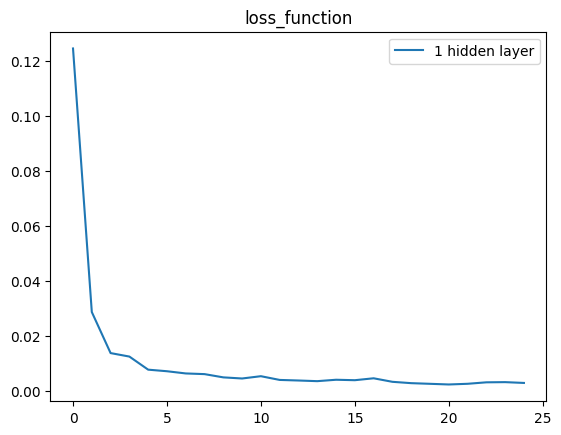

In [20]:
plt.plot(fit_model.history["loss"])
plt.title("loss_function")
plt.legend(["1 hidden layer"])
plt.show()

In [21]:
file_path = 'WorldBankFertilityModel.h5'

# Export the model to a HDF5 file
nn.save(file_path)

/Users/davidrosenbloom/anaconda3/envs/dev/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
